<a href="https://colab.research.google.com/github/SantiDrelewicz/Aprendizaje-Automatico/blob/main/AA-II/notebooks/notebook_12_representation_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Representation Learning

Esta actividad presenta tres enfoques clave para el aprendizaje de representaciones, desde distintas perspectivas del modelado generativo y del procesamiento del lenguaje natural:
- Autoencoders: redes que aprenden a comprimir y reconstruir datos, forzando al modelo a capturar información esencial en un espacio latente de menor dimensión.
- GANs: modelos que aprenden a generar datos realistas mediante una competencia entre un generador y un discriminador.
- Word Embeddings: vectores densos que representan palabras en un espacio continuo, capturando relaciones semánticas a partir del contexto en grandes corpus no etiquetados.

En todos los casos, el objetivo es aprender representaciones internas útiles mediante tareas generativas o auto-supervisadas, como la reconstrucción, la generación de ejemplos nuevos o la predicción de contexto.

⸻

Los objetivos son:
- Entrenar un autoencoder simple y visualizar su espacio latente
- Usar la representación latente aprendida para generar ejemplos nuevos
- Entrenar una GAN básica y observar cómo aprende a generar muestras realistas
-  Comparar distintas variantes de modelos de clasificación utilizando word embeddings:
	- Inicializados aleatoriamente (rand)
	- Preentrenados fijos (static)
	- Preentrenados ajustables (non-static)
- Analizar cómo el uso de representaciones distribuidas impacta en el rendimiento de modelos supervisados de texto.



---
## 1. Autoencoder

### 1.1. Repaso teórico

Los autoencoders son modelos que permiten apredener representaciones latentes de datos sin etiquetas. Vamos a considerar que los autoenconders son redes cuyo objetivo es aprender la función identidad, de esta forma, durante el procedimiento de entrenamiento se espera que puedan aprender a comprimir los datos de entrada.
Matemáticamente, sea $\boldsymbol{x}\in {D}$, llamemos `Encoder` a $g_\varphi(\cdot)$ y `Decoder` a $f_\theta(\cdot).$ Consideremos $\boldsymbol{z}=g_\varphi(\boldsymbol{x})$, generalmente de dimensión menor al input $\boldsymbol{x}$, y sea $\boldsymbol{x}\prime=f_\theta(g_\varphi(\boldsymbol{x})).$ El obejtivo es aprender los parámetros $\varphi$ y $\theta$ tales que: $x\approx x\prime$. Es decir:

$$
{L}(\varphi,\theta)=\mathbb{E_{x}}[\|x - f_\theta(g_\varphi(\boldsymbol{x}))\|_2^2]
$$


### 1.2. Ejercicios de autoencoder

Para los siguientes ejercicios, vamos a usar el dataset de Fashion-MNIST. Vamos a comparar los siguientes modelos:
1. PCA (usando sklearn)
2. Autoencoder Lineal sin función de activación
3. DeepAutoencoder
4. DenoisingAutoencoder


In [ ]:
#@title Importamos librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)
torch.manual_seed(42)


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerías Importadas")

In [ ]:
# CONFIGURACIONES
BATCH_SIZE = 256

In [ ]:
# definimos la transformación para preprocesar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28×28 → 784
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Nros. de Train: {len(train_dataset)}")
print(f"Nros. de Test: {len(test_dataset)}")
print(f"Shape de la imagenes: {train_dataset[0][0].shape}")
print(f"# de clases: {len(class_names)}")

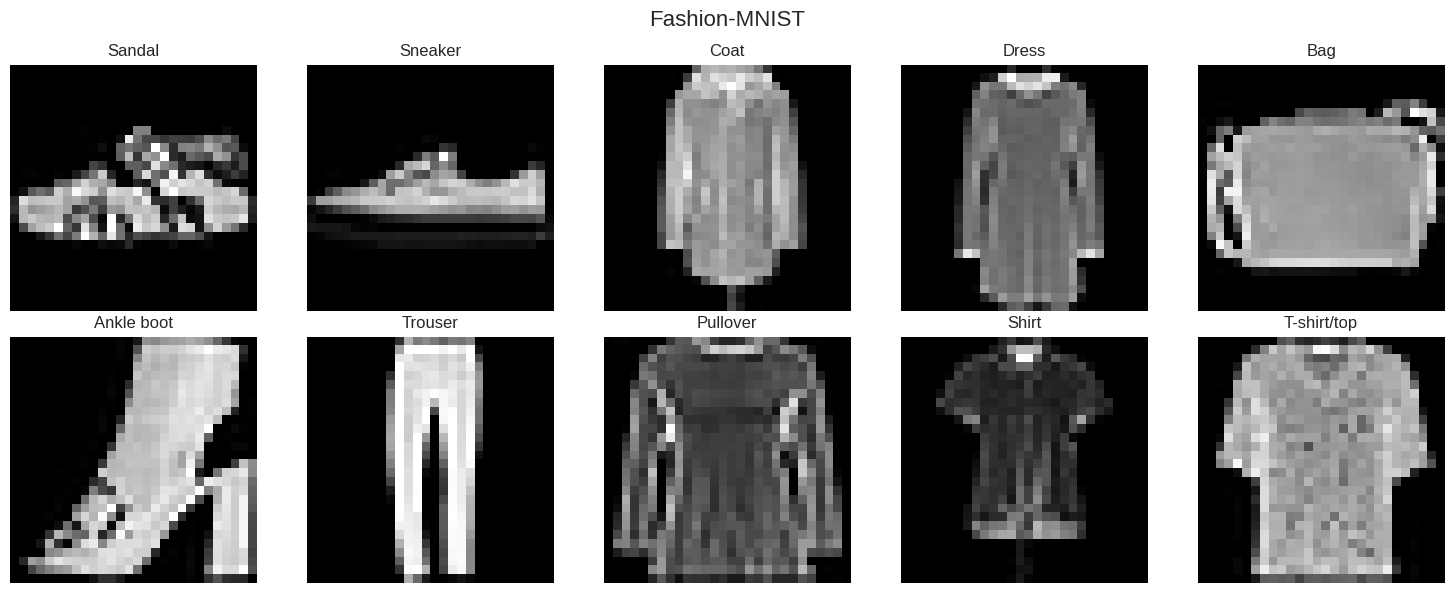

In [ ]:
#@title Veamos algunos ejemplos para cada clase
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Fashion-MNIST', fontsize=16)


class_samples = {}
for data, target in train_loader:
    for i in range(len(target)):
        label = target[i].item()
        if label not in class_samples:
            class_samples[label] = data[i]
        if len(class_samples) == 10:
            break
    if len(class_samples) == 10:
        break


for idx, (class_idx, image) in enumerate(class_samples.items()):
    row, col = idx // 5, idx % 5
    image = image.view(28, 28)
    axes[row, col].imshow(image.squeeze(), cmap='gray')
    axes[row, col].set_title(f'{class_names[class_idx]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

#### 1.2.1. PCA con Autoencoder Lineal

**PCA con los vectores achatados**

*Repaso de PCA.* PCA es una técnica de reducción de dimensionalidad para simplificar conjuntos de datos sin perder demasiada información relevante. El objetivo es transformar las variables originales en un nuevo conjunto de variables ortogonales: las componentes principales, que capturan la máxima varianza posible en los datos con la menor cantidad de dimensiones.
Formalmente, el objetivo de PCA es encontrar una matriz de proyección $\mathbf{W} \in \mathbb{R}^{d \times k}$ (con $k \leq d$) tal que las nuevas variables $\mathbf{Z} = \mathbf{X} \mathbf{W}$ conserven la mayor varianza posible.

Se expresa como el siguiente problema de optimización:
$$
\max_{\mathbf{W} \in \mathbb{R}^{d \times k}} \; \operatorname{Tr} \left( \mathbf{W}^\top \mathbf{S} \mathbf{W} \right) \quad \text{sujeto a} \quad \mathbf{W}^\top \mathbf{W} = \mathbf{I}_k
$$
donde:

- $\mathbf{S} = \frac{1}{n} \mathbf{X}^\top \mathbf{X}$ es la matriz de covarianza estimada de los datos,
- $\operatorname{Tr}(\cdot)$ denota la traza de una matriz,
- $\mathbf{I}_k$ es la matriz identidad de tamaño $k$.

La solución óptima está dada por las $k$ autovectores de $\mathbf{S}$ correspondientes a los $k$ autovalores más grandes. Estos vectores definen las direcciones principales en las que los datos varían más.

A partir de un subconjunto de imágenes achatadas, realizarás los siguientes:

1.	Construí la matriz de datos.
Extraé un batch de imágenes del conjunto de entrenamiento y convertilo en una matriz de tamaño (N, 784), donde cada fila representa una imagen de 28x28 píxeles aplanada.
2.	Ajustá el modelo PCA. Aplicá PCA con 64 componentes principales y ajustalo a los datos.
3.	Graficá la varianza acumulada explicada en función del número de componentes principales.
4. Visualizá las primeras 10 componentes principales como imágenes de 28x28 píxeles.
5.	Reconstrucción. Tomá un subconjunto de 10 imágenes, proyectalas en las componentes principales y reconstruílas usando la transformación inversa. Compará las imágenes originales y las reconstruidas.


In [ ]:
# 1) TODO
X =   # shape (256,784)
# 2) fit PCA
pca = PCA(n_components=64)
pca.fit(X)

# 3)
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('componentes'); plt.ylabel('varianza explicada cumulativa(%)')
plt.show()


In [ ]:
# Veamos los primeros 10 PCs
pcs = pca.components_[:10].reshape(-1,28,28)
fig, axs = plt.subplots(2,5,figsize=(10,4))
for i,ax in enumerate(axs.flatten()):
    ax.imshow(pcs[i], cmap='gray'); ax.axis('off')
plt.show()

In [ ]:
X_test = X[:10]
X_rec = pca.inverse_transform(pca.transform(X_test))
fig,axs = plt.subplots(2,10,figsize=(15,3))
for i in range(10):
    axs[0,i].imshow(X_test[i].reshape(28,28), cmap='gray'); axs[0,i].axis('off')
    axs[1,i].imshow(X_rec[i].reshape(28,28), cmap='gray'); axs[1,i].axis('off')
plt.suptitle('arriba: original — abajo: reconstruccion PCA '); plt.show()

**Con Autoencoder lineal sin función de activación**

En este ejercicio entrenarás un autoencoder lineal sobre el mismo dataset. El modelo consta de una red con arquitectura simétrica:

*	Encoder: una única capa lineal que proyecta la imagen a un espacio latente de dimensión $d$.
*	Decoder: una única capa lineal seguida de una función sigmoide, que proyecta el espacio latente de vuelta al espacio de imágenes.

El código entrena este modelo usando descenso por gradiente estocástico (`SGD`) y error cuadrático medio (`MSE`) como función de pérdida.

In [ ]:
# CONFIGURACIONES para LinearAE
LATENT_DIM=10
LR=0.5
MAX_EPOCH=20

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=2):
        super().__init__()
        # encoder = Linear(784 a latent_dim)
        self.encoder = # TODO
        # decoder = Linear(latent_dim a 784) + sigmoid para que los valores de los pixeles estén en [0,1]
        self.decoder = # TODO
    def forward(self, x):
        # TODO
        return xrec, z

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = Autoencoder(latent_dim=LATENT_DIM).to(device)
opt    = optim.SGD(model.parameters(), lr=LR)
crit   = nn.MSELoss()

# 4) Train
for epoch in range(MAX_EPOCH):
    model.train()
    total_loss = 0
    for xb, _ in train_loader:
       # TODO

    print(f"Epoch {epoch+1:2d}  loss={total_loss/len(train_loader):.4f}")

Usá el modelo entrenado para obtener los vectores latentes $\mathbf{z} \in \mathbb{R}^2$ de un batch de imágenes del conjunto de test. Creá un scatter plot donde cada punto representa una imagen codificada por el autoencoder en el espacio latente. Usá el color para indicar la etiqueta de clase de cada imagen.

In [ ]:
model.eval()
xb, yb = next(iter(test_loader))
xb = xb.to(device)
with torch.no_grad():
    _, z = model(xb)
z = z.cpu().numpy()
yb = yb.numpy()

plt.figure(figsize=(6,5))
scatter = plt.scatter(z[:,0], z[:,1], c=yb, cmap='tab10', s=5)
plt.legend(*scatter.legend_elements(), title="class", loc="upper right")
plt.title("Espacio Latente 2D de Fashion-MNIST")
plt.xlabel("z0"); plt.ylabel("z1")
plt.show()

Compará los resultados entre PCA y el Autoencoder Lineal, tomando un batch del test_loader. ¿Qué observa?

In [ ]:
# 6) Reconstrucción
# Comparación entre PCA y Autoencoder

# Obtener datos de prueba
xb, _ = next(iter(test_loader))
xb = xb.to(device)
X_test = xb.cpu().numpy()

# Reconstrucción con PCA
# Usar solo las primeras 10 componentes principales
X_pca_10 = pca.transform(X_test)[:, :10]  # (B, 10)
# Redimensionar a (B, 64) rellenando con ceros
X_pca_10_pad = np.zeros((X_pca_10.shape[0], 64))
X_pca_10_pad[:, :10] = X_pca_10
# Reconstrucción desde solo 10 PCs
X_pca_rec_10 = pca.inverse_transform(X_pca_10_pad)

# Reconstrucción con Autoencoder
model.eval()
with torch.no_grad():
    xr, _ = model(xb)
X_ae_rec = xr.cpu().numpy()

# Visualización
n = 10
fig, axs = plt.subplots(3, n, figsize=(15, 5))
for i in range(n):
    axs[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(X_pca_rec_10[i].reshape(28, 28), cmap='gray')
    axs[1, i].axis('off')
    axs[2, i].imshow(X_ae_rec[i].reshape(28, 28), cmap='gray')
    axs[2, i].axis('off')
axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("PCA", fontsize=12)
axs[2, 0].set_ylabel("Autoencoder", fontsize=12)
plt.suptitle("Reconstrucción: Original vs PCA vs Autoencoder", fontsize=14)
plt.tight_layout()
plt.show()

# MSE cuantitativo
from sklearn.metrics import mean_squared_error

mse_pca = mean_squared_error(X_test, X_pca_rec_10)
mse_ae  = mean_squared_error(X_test, X_ae_rec)

print(f"MSE reconstrucción PCA:         {mse_pca:.4f}")
print(f"MSE reconstrucción Autoencoder: {mse_ae:.4f}")

#### 1.2.2. Deep Autoencoder

¿Qué ocurre si ahora agregamos más capas densas y funciones de activación tanto para el `encoder` como para el `decoder`?

Experimentar con diferentes arquitecturas, dimensión del vector latente, optimizadores, etc. Por ejemplo, 2 capas densas con ReLU con Adam.

El procedimiento para entrenar sigue igual.

In [ ]:
# CONFIGURACIONES para DeepAE
LATENT_DIM=10
LR=1e-3
MAX_EPOCH=20

In [ ]:
class DeepAutoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=10):
        super().__init__()
        # TODO

    def forward(self, x):
        #TODO
        return xrec, z

model_deep = DeepAutoencoder(latent_dim=LATENT_DIM).to(device)
opt = optim.Adam(model_deep.parameters(), lr=LR)
crit = nn.MSELoss()

# Train
for epoch in range(MAX_EPOCH):
    model_deep.train()
    total_loss = 0
    for xb, _ in train_loader:
        xb = xb.to(device)
        # TODO
    print(f"[Deep] Epoch {epoch+1:2d}  loss={total_loss/len(train_loader):.4f}")


In [ ]:
# Reconstrucción visual vs Autoencoder lineal
model_deep.eval()
xb, _ = next(iter(test_loader))
xb = xb.to(device)
X_test = xb.cpu().numpy()

# Forward pass en deepAE
with torch.no_grad():
    xr_deep, _ = model_deep(xb)
X_deep_rec = xr_deep.cpu().numpy()

# Forward pass en LinearAE
with torch.no_grad():
    xr_linear, _ = model(xb)
X_linear_rec = xr_linear.cpu().numpy()

n = 10
fig, axs = plt.subplots(3, n, figsize=(15, 6))
for i in range(n):
    axs[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axs[1, i].imshow(X_ae_rec[i].reshape(28, 28), cmap='gray')
    axs[2, i].imshow(X_deep_rec[i].reshape(28, 28), cmap='gray')
    for row in range(3):
        axs[row, i].set_xticks([])
        axs[row, i].set_yticks([])
        axs[row, i].spines[:].set_visible(False)

axs[0, 0].set_ylabel("Original", fontsize=12)
axs[1, 0].set_ylabel("Linear AE", fontsize=12)
axs[2, 0].set_ylabel("Deep AE", fontsize=12)

plt.suptitle("Reconstrucción: Original vs PCA vs Linear AE vs Deep Autoencoders", fontsize=14)
plt.tight_layout()
plt.show()

mse_deep = mean_squared_error(X_test, X_deep_rec)
print(f"MSE reconstrucción Deep Autoencoder: {mse_deep:.4f}")

#### 1.2.3. [Opcional] Denoising Autoencoder

Modificá el entrenamiento del autoencoder profundo para que funcione como un Denoising Autoencoder. Esto implica:

1.	Agregar ruido gaussiano a las imágenes de entrada durante el entrenamiento.
2.	Entrenar el autoencoder para que reconstruya la imagen original limpia a partir de su versión ruidosa.

Instrucciones:
- Usá ruido aditivo gaussiano: `x_noisy = x + noise`, con `noise `$\sim \mathcal{N}(0, \sigma^2)$ (por ejemplo, $\sigma^2 = 0.3$).
- Durante el entrenamiento, el input del modelo debe ser `x_noisy`, pero la pérdida debe calcularse respecto a `x` (sin ruido).
- Evaluá la reconstrucción visualmente comparando la imagen original, la ruidosa y la reconstruida.

In [ ]:
# CONFIGURACIONES para DnoiseAE
LATENT_DIM=10
LR=1e-3
MAX_EPOCH=20
NOISE_FACTOR=0.3

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=10):
        super().__init__()
        # TODO

    def forward(self, x):
        # TODO
        return xrec, z

    @staticmethod
    def add_noise(x, noise_factor=0.3):
      # TODO
      # Asegurarse que el output esté entre 0,1

model_denoise = DenoisingAutoencoder(latent_dim=LATENT_DIM).to(device)
opt = optim.Adam(model_denoise.parameters(), lr=LR)

# Train with noise
for epoch in range(MAX_EPOCH):
    model_denoise.train()
    total_loss = 0
    for xb, _ in train_loader:
       # TODO
    print(f"[Denoising] Epoch {epoch+1:2d}  loss={total_loss/len(train_loader):.4f}")


In [ ]:
# Reconstrucción visual DenoiseAE vs Deep AE
xb, _ = next(iter(test_loader))
xb = xb.to(device)
X_test = xb.cpu().numpy()

# Forward pass en DenoiseAE
model_denoise.eval()
with torch.no_grad():
    xb_noisy = model_denoise.add_noise(xb)
    xr_denoise, _ = model_denoise(xb_noisy)
X_denoise_rec = xr_denoise.cpu().numpy()

# Foward pass en DeepAE
with torch.no_grad():
    xr_deep, _ = model_deep(xb)
X_deep_rec = xr_deep.cpu().numpy()

fig, axs = plt.subplots(4, n, figsize=(15, 8))
for i in range(n):
    axs[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axs[1, i].imshow(X_deep_rec[i].reshape(28, 28), cmap='gray')
    axs[2, i].imshow(xb_noisy[i].cpu().numpy().reshape(28,28), cmap='gray')
    axs[3, i].imshow(X_denoise_rec[i].reshape(28, 28), cmap='gray')
    for row in range(4):
        axs[row, i].set_xticks([])
        axs[row, i].set_yticks([])
        axs[row, i].spines[:].set_visible(False)

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Deep AE")
axs[2, 0].set_ylabel("Noisy input")
axs[3, 0].set_ylabel("Denoise AE")

plt.suptitle("Reconstrucción con Denoising Autoencoder", fontsize=14)
plt.tight_layout()
plt.show()

mse_deep = mean_squared_error(X_test, X_deep_rec)
print(f"MSE reconstrucción Deep Autoencoder: {mse_deep:.4f}")
mse_denoise = mean_squared_error(X_test, X_denoise_rec)
print(f"MSE reconstrucción Denoising Autoencoder: {mse_denoise:.4f}")

---
## 2. GANs

### 2.1. Repaso teórico

Las GANs son una clase de modelos generativos basados en juegos de suma cero entre dos redes neuronales: el generador y el discriminador.
- Generador $G_\theta(z)$: Toma como entrada un vector aleatorio $z \sim p_z(z)$ (por ejemplo, una gaussiana estándar), y genera una muestra sintética $G_\theta(z)$ que intenta imitar una muestra real $x \sim p_{\text{data}}$.
- Discriminador $D_\phi(x)$: Toma una muestra $x$ (real o generada) y predice la probabilidad de que provenga del conjunto de datos reales. Su objetivo es distinguir entre datos reales y falsos.

El entrenamiento se modela como un juego minimax con la siguiente función objetivo:

$$
\min_G \max_D ; V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]
$$

El discriminador intenta maximizar su capacidad de distinguir muestras reales de las generadas, maximizando la probabilidad de asignar correctamente las etiquetas reales (1 para datos reales, 0 para generados).

El generador intenta “engañar” al discriminador, produciendo muestras tales que $D(G(z)) \to 1$, es decir, que sean clasificadas como reales.

*Observar* que la función de pérdida que usaremos para entrenar es la Binary Cross Entropy.

### 2.2. Ejercicio

#### 2.2.1. GANs

1. Cargar y visualizar el dataset
2. Definir el Discriminador y el Generador
3. Entrenar el GAN
4. Visualizar las imágenes generadas

In [ ]:
import kagglehub

path = kagglehub.dataset_download("spandan2/cats-faces-64x64-for-generative-models")

print("Path to dataset files:", path)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torchvision.utils as vutils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# CONFIGURACIONES GAN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Usando {device}, sugerencia: usar T4 en colab para GPU')
latent_dim = 100
image_size = 64
image_channels = 3
batch_size = 256
lr = 2e-4
epochs = 50

In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transforms = transforms.Compose([transforms.Resize(image_size),
                         transforms.CenterCrop(image_size),
                         transforms.ToTensor(),
                         transforms.Normalize(*stats),
                         transforms.Lambda(lambda x: x.view(-1))  # Aplano la imagen
                        ])

data = datasets.ImageFolder(
    root= # TODO, completar con el path en la celda de kaggle
    transform=transforms)
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=4, shuffle=True)

In [ ]:
#@title veamos algunos ejemplos del dataset
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images.view(-1, image_channels, image_size, image_size), nmax)
        break

show_batch(train_loader)


Usaremos la siguiente arquitectura inicial para el Generador, pueden probar con otras.  3 capas lineales y cada una está seguida de una función de activación ReLU, excepto la última que usa Tanh. Para el discriminador, usaremos 3 capas lineales con activación LeakyReLU y la última capa sigmoidea (para retornar probabilidades).


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=256, output_dim=image_channels*image_size*image_size):
        super().__init__()
        # TODO # Salida en [-1, 1]


    def forward(self, z):
        return self.model(z)

G = Generator(latent_dim).to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=image_channels*image_size*image_size, hidden_dim=256):
        super().__init__()
        # TODO

    def forward(self, x):
        return self.model(x)

D = Discriminator().to(device)

Para cada epoch,
1. Entrenamiento del Discriminador D
	1.	Tomar un mini-batch de imágenes reales del dataset: real_imgs
	2.	Generar un mini-batch de imágenes falsas con el generador.
  3. Pasar imágenes reales por D y calcular función de pérdida para D.
  4. Pasar imágenes falsas por D y calcular función de pérdida.
  5. Sumar y backpropagar para actualizar los pesos en D.
2. Entrenamiento al Generador G
  1. Generar un nuevo mini-batch de ruido.
  2. Generar imágenes falsas con G.
  3. Pasar las imágenes falsas por D.
  4. Calcular la función de pérdida del generador.
  5. Actualizar los pesos de G.

In [ ]:
# Probar diferentes lr
criterion = #TODO , qué loss usamos?
optimizer_G = optim.Adam(G.parameters(), lr=2e-4)
optimizer_D = optim.Adam(D.parameters(), lr=2e-4)

In [ ]:
fixed_noise = torch.randn(32, latent_dim).to(device)
epochs = 50

for epoch in range(epochs):
    for real_imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # ======== Discriminador ========
        # TODO

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # ======== Generador ========
        # TODO

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 10 == 0 or epoch == epochs - 1:
      print(f"Epoch {epoch+1}/{epochs} - Loss D: {loss_D.item():.4f} - Loss G: {loss_G.item():.4f}")
      # Mostrarmos las imágenes generadas
      with torch.no_grad():
          gen_imgs = G(fixed_noise).view(-1, image_channels, image_size, image_size)
          gen_imgs = (gen_imgs + 1) / 2  # Desnormalizar
          grid = vutils.make_grid(gen_imgs, nrow=8)
          plt.figure(figsize=(8,8))
          plt.axis("off")
          plt.title(f"Imágenes generadas - Época {epoch+1}")
          plt.imshow(np.transpose(grid.cpu(), (1,2,0)))
          plt.show()

#### 2.2.2. [Opcional] DCGAN

Mejorar la calidad de las imágenes generadas usando una arquitectura más profunda basada en convoluciones.

Sugerencia, para el generador usar ConvTranspose2d+BatchNorm+Relu y última capa con Tanh.
Para el discriminador usar Conv2d + LeakyRelu y última capa sigmoid.

In [ ]:
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        # TODO

    def forward(self, z):
        return self.model(z)

class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO

    def forward(self, x):
        return self.model(x).view(-1)

dcgan_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),  # Normalizar entre [-1, 1]
]) # el input es una imagen, por lo que no vamos a aplanarlo.

dataset = # TODO
dataloader = # TODO


# Inicializar
dcgan_G = DCGANGenerator().to(device)
dcgan_D = DCGANDiscriminator().to(device)

#
criterion = # TODO
optimizer_G = # TODO
optimizer_D = # TODO Sug: usar Adam

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

EPOCHS=25
for epoch in range(EPOCHS):
    for real_imgs, _ in tqdm(dataloader, desc=f"[DCGAN] Epoch {epoch+1}/25"):
        real_imgs = real_imgs.to(device)

        # ======== Discriminador ========
        batch_size = real_imgs.size(0)


        # ======== Generador ========
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)


    # Visualizar resultados
    with torch.no_grad():
        samples = dcgan_G(fixed_noise).detach().cpu()
        grid = vutils.make_grid((samples + 1) / 2, nrow=8)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"[DCGAN] Imágenes generadas - Epoch {epoch+1}")
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.show()

## 3. Word Embeddings: Clasificación de Sentimientos con y sin Embeddings Preentrenados

Como ya hemos visto, para entrenar modelos de clasificación de texto necesitamos representar las palabras de forma numérica para que el modelo pueda entederlas.
Por lo visto en la clase teórica, sabemos que la mejor forma de representar las palabras es mediante **Embeddings**, es decir, vectores densos de dimensión acotada que representan las semánticas de las palabras.

En la clase vimos modelos de Embeddings. Ahora queremos utilizar los embeddings pre-entrenados (que podemos obtener de Word2Vec o Glove), aprovechando que son ricos en información, para poder entrenar un modelo de clasificación.

Al entrenar un modelo de clasificación de texto, tenemos básicamente tres enfoques respecto a cómo inicializar y manejar estos embeddings pre-entrenados:



*   **Random**
*   **Estático (Static)**
* **No Estático (Non-Static)**



 **Modelo Random**

En el enfoque random, no se utilizan embeddings pre-entrenados como GloVe. En cambio, se agrega una capa de embeddings al modelo que comienza con vectores inicializados aleatoriamente, normalmente usando una distribución uniforme o normal.

Los embeddings se ajustan durante el entrenamiento. Es decir, los vectores van cambiando para adaptarse a la tarea específica de clasificación a medida que el modelo se entrena con los datos.

**Modelo Estático**

El enfoque estático consiste en inicializar los embeddings usando vectores pre-entrenados (en este caso, los de GloVe) y mantener estos embeddings fijos durante todo el entrenamiento del modelo.

Otro enfoque sería verlo como si nuestro modelo tomara los embeddings pre-entrenados como input de su red.

En la práctica, se agrega una capa de embeddings inicializada con los embeddings de GloVe, y que permanece constante (`requires_grad = False`). De esta manera los embeddings no se ven afectados durante el backpropagation.


**Modelo no Estático**

El enfoque no estático combina lo mejor de ambos mundos. Aquí, se inicializan los embeddings con vectores pre-entrenados (GloVe), pero se permite que se actualicen durante el entrenamiento, adaptándose así al contexto específico del dataset.

Se actualizan los vectores durante el entrenamiento. Es decir, los embeddings empiezan con conocimiento previo, pero se adaptan a la tarea específica.

**Enfoque Generalista vs Especialista**

A la hora de resolver una tarea específica, nos interesa saber el grado de adaptación que tiene un modelo para resolver dicha tarea.

En general, podemos dividir a los modelos en dos clases:

**Modelos Pre-entrenados (Enfoque Generalista)**
 Son modelos que han sido entrenados con corpus muy amplios, diversos, y generalmente grandes. Buscan cubrir una gran variedad de contextos y dominios, capturando relaciones semánticas generales y conocimiento lingüístico universal.

**Ejemplos**: Embeddings (Word2Vec, GloVe), BERT, GPT.

**Modelos Finetunneados (Enfoque Especialista)**
 Son modelos que han sido entrenados o adaptados sobre textos muy específicos de un dominio concreto. En general, se ajustan específicamente a la terminología, estilo, jerga y patrones lingüísticos de ese dominio particular.

**Ejemplos**: BERT adaptado para textos clínicos, GPT especializado en resúmenes científicos.


### Clasificación de sentimientos

En el sección vamos a comparar estos paradigmas en la tarea de clasificación de sentimientos.

Para ello, utilizaremos el dataset [dair-ai/emotion](https://github.com/dair-ai/emotion_dataset?tab=readme-ov-file).

el objetivo de esta parte es entrenar tres modelos:

*   Un modelo inicializado con embeddings random
*   Un modelo que utilice los embeddings de GloVe como embeddings estáticos.
* Un modelo que utilice los embeddings de GloVe como embeddings no estáticos.

Para ello utilizaremos una [CNN Text Classification Network](https://aclanthology.org/D14-1181.pdf), que usa filtros especiales (llamados convolucionales) para analizar el texto, identificar patrones importantes y realizar la clasificación de sentimientos con precisión.

In [ ]:
!pip install datasets flair gensim -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q numpy==1.26.4 pandas==2.2.1 --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 192.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 163.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 182.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 187.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 197.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
import random
from sklearn.metrics import classification_report
import gensim

### 3.1. Cargando los embeddings

In [ ]:
def custom_embed_sentence(sentence_text, glove_embedding):
    """
    Convierte una oración en embeddings usando un modelo GloVe preentrenado.

    Args:
        sentence_text (str): Texto de la oración a procesar
        glove_embedding: Modelo de embeddings GloVe de Flair

    Returns:
        embeddings : Tensor 2D con shape (num_tokens, embedding_dim)
                     donde cada fila es el embedding de un token.
                     Retorna tensor vacío si no hay tokens.
    """
    sentence = Sentence(sentence_text)
    glove_embedding.embed(sentence)

    # TODO

    return embeddings

In [ ]:
glove_embeddings = WordEmbeddings('glove')

In [ ]:
custom_embed_sentence('hi how are you', glove_embeddings).shape

### 3.2 Cargando el Dataset

In [ ]:
dataset = load_dataset("dair-ai/emotion")
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
train_texts[:5]

In [ ]:
sentence_text = "i am feeling grouchy"
sentence = Sentence(sentence_text)
glove_embeddings.embed(sentence)

print("Sentece:", sentence_text)
print("Word Embeddings:")
for token in sentence:
  print("Word: ", token.text)
  print("Embedding shape:", token.embedding.shape)
  print("Embedding vector: ", token.embedding[:10])

**Preparando la data**

In [ ]:
emotion_to_label = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
label_to_emotion = {v: k for k, v in emotion_to_label.items()}

In [ ]:
# @title Armando el vocabulario
vocab = set()
for text_sentence in train_texts:
  sentence = Sentence(text_sentence)
  for token in sentence:
    vocab.add(token.text)

vocab.add('<UNK>')
vocab.add('<PAD>')

In [ ]:
word2idx = {w: idx for (idx, w) in enumerate(vocab)}
idx2word = {idx: w for (idx, w) in enumerate(vocab)}


In [ ]:
text = 'i am very happy'
sentence = Sentence(text)
tokens = [token for token in sentence]
print(tokens)

In [ ]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, word2idx, max_length=30):
      """
      Inicializa el dataset de análisis de sentimientos.

      Args:
          texts (list): Lista de textos/oraciones para clasificar
          labels (list): Lista de etiquetas correspondientes a cada texto
          vocab (dict): Vocabulario completo (puede no usarse directamente)
          word2idx (dict): Diccionario que mapea palabras a índices numéricos
          max_length (int, optional): Longitud máxima de secuencia. Por defecto 30.
      """
      #TODO
    def __len__(self):
      """
      Retorna el número total de elementos en el dataset.

      Returns:
          int: Cantidad de textos/muestras en el dataset
      """
      # TODO

    def __getitem__(self, idx):

      """
      Obtiene un elemento del dataset por su índice.

      Procesa el texto tokenizándolo, convirtiéndolo a índices numéricos,
      y aplicando padding/truncation para mantener longitud fija.

      Args:
          idx (int): Índice del elemento a obtener

      Returns:
          tuple: (tensor_indices, tensor_label) dtype=torch.long
              - tensor_indices: tensor con índices de palabras (longitud max_length)
              - tensor_label: tensor con la etiqueta correspondiente
      """
      # TODO


In [ ]:
sentiment_dataset = SentimentDataset(train_texts, train_labels, vocab, word2idx)
train_dataset, val_dataset = train_test_split(sentiment_dataset, test_size=0.4, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

### 3.3. Construyendo la matriz de embeddings

In [ ]:
vocab_size = len(vocab)
embed_dim = glove_embeddings.embedding_length

embedding_matrix = torch.zeros((vocab_size, embed_dim), dtype=np.float32)
for word in vocab:
    sentence = Sentence(word)
    glove_embeddings.embed(sentence)
    embedding_vector = sentence[0].embedding.cpu().numpy()
    i=word2idx[word]
    embedding_matrix[i,:] = embedding_vector



In [ ]:
def look_up_table(word_idx):
    x = torch.zeros(vocab_size).float()
    x[word_idx] = 1.0
    return x

### 3.4. Creando los modelos

Completar el código para modificar el comportamiento de la red en base al `model_type` que puede ser `rand`, `static` o `non-static`.

Explorar la clase `nn.Embedding`. [Link](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) a la documentación.

In [ ]:
import torch
import numpy as np
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from datasets import load_dataset
import torch.nn as nn
import torch.nn.functional as F

class HighLevelTextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, class_num, filter_sizes, num_filters,
                 dropout, model_type='non-static', pretrained_embeddings=None):
        """
        Args:
            vocab_size: Size of the vocabulary.
            embed_dim: Dimensionality of word embeddings.
            class_num: Number of output classes.
            filter_sizes: List of filter (kernel) sizes (e.g., [3,4,5]).
            num_filters: Number of filters per filter size.
            dropout: Dropout rate.
            model_type: 'rand', 'static', or 'non-static'
            pretrained_embeddings: numpy array of shape (vocab_size, embed_dim) or None.
        """
        super(HighLevelTextCNN, self).__init__()
        self.model_type = model_type

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        if pretrained_embeddings is not None:
          if model_type # TODO
          # TODO


        # Build convolutional blocks for each filter size
        self.conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, num_filters, kernel_size=(fs, embed_dim)),
                nn.ReLU()
            ) for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), class_num)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, sentence_length)
        """
        # 1. Embedding: (batch_size, sentence_length, embed_dim)
        x = self.embedding(x)
        # 2. Add channel dimension: (batch_size, 1, sentence_length, embed_dim)
        x = x.unsqueeze(1)
        conv_results = []
        for conv in self.conv_blocks:
            conv_out = conv(x)          # (batch_size, num_filters, L, 1)
            conv_out = conv_out.squeeze(3)  # (batch_size, num_filters, L)
            pooled = F.max_pool1d(conv_out, kernel_size=conv_out.size(2)).squeeze(2)  # (batch_size, num_filters)
            conv_results.append(pooled)
        cat = torch.cat(conv_results, 1)  # (batch_size, num_filters * len(filter_sizes))
        drop = self.dropout(cat)
        logits = self.fc(drop)
        return logits

In [ ]:
# @title Hiperparámetros
class_num = len(emotion_to_label)
filter_sizes = [3, 4]
num_filters = 50
dropout = 0.2
num_epochs = 20

In [ ]:
# @title Instanciando los modelos

model_rand = HighLevelTextCNN(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    class_num=class_num,
    filter_sizes=filter_sizes,
    num_filters=num_filters,
    dropout=dropout,
    model_type='rand',
    pretrained_embeddings=None
)


model_static = HighLevelTextCNN(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    class_num=class_num,
    filter_sizes=filter_sizes,
    num_filters=num_filters,
    dropout=dropout,
    model_type='static',
    pretrained_embeddings=embedding_matrix
)

model_non_static = HighLevelTextCNN(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    class_num=class_num,
    filter_sizes=filter_sizes,
    num_filters=num_filters,
    dropout=dropout,
    model_type='non-static',
    pretrained_embeddings=embedding_matrix
)


### 3.5 Training Loop

Explicar qué hace este loop de entrenamiento.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

def train_model(model, train_loader, val_loader, num_epochs, model_type):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss() #Ya incluye la softmax adentro
    optimizer = optim.Adam(model.parameters(), lr=0.0003)

    train_losses = []
    val_losses, val_f1 = [], []
    for epoch in range(num_epochs):
        model.train()

        train_loss = 0

        tqdm_train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]", leave=False)

        for batch_inputs, batch_labels in tqdm_train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()

        val_loss = 0
        correct = 0
        total = 0

        tqdm_val_loader = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]", leave=False)
        with torch.no_grad():
            for batch_inputs, batch_labels in tqdm_val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += batch_labels.size(0)
                correct += predicted.eq(batch_labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"model_{model_type} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {100*correct/total:.2f}%")

    return train_losses, val_losses


In [ ]:
train_loss_rand, val_loss_rand = train_model(model_rand, train_loader, val_loader, num_epochs, 'rand')

In [ ]:
Lotrain_loss_static, val_loss_static = train_model(model_static, train_loader, val_loader, num_epochs, 'static')

In [ ]:
train_loss_non_static, val_loss_non_static = train_model(model_non_static, train_loader, val_loader, num_epochs, 'non-static')

In [ ]:
def plot_losses(train_losses, val_losses, model_type):
  plt.plot(train_losses, label=f'Train Loss')
  plt.plot(val_losses, label=f'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'{model_type} Model Training and Validation Losses')
  plt.legend()
  plt.show()

##### Aca idealmente tenemos las curvas de entrenamiento para los tres modelos

In [ ]:
plot_losses(train_loss_rand, val_loss_rand, 'Random Non Static')

In [ ]:
plot_losses(train_loss_static, val_loss_static, 'Static')

In [ ]:
plot_losses(train_loss_non_static, val_loss_non_static, 'Non Static')

In [ ]:
epochs = range(1, len(train_loss_rand) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_rand, label='Random Non-Static Model')
plt.plot(epochs, train_loss_static, label='Static Model')
plt.plot(epochs, train_loss_non_static, label='Non-Static Model')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves for 3 Models')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, val_loss_rand, label='Random Non-Static Model')
plt.plot(epochs, val_loss_static, label='Static Model')
plt.plot(epochs, val_loss_non_static, label='Non-Static Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Curves for 3 Models')
plt.legend()
plt.show()

In [ ]:
def generate_classification_report_table(model, dataset, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels in tqdm(dataset, desc="Generating predictions"):
            embeddings = embeddings.to(device)
            outputs = model(embeddings)
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate the classification report
    report = classification_report(all_labels, all_predictions, target_names=emotion_to_label.values(), output_dict=True)

    # Convert the report to a DataFrame
    df = pd.DataFrame(report).transpose()

    # Reorder the columns
    df = df[['precision', 'recall', 'f1-score', 'support']]

    # Format the values
    df['precision'] = df['precision'].apply(lambda x: f"{x:.6f}")
    df['recall'] = df['recall'].apply(lambda x: f"{x:.6f}")
    df['f1-score'] = df['f1-score'].apply(lambda x: f"{x:.6f}")
    df['support'] = df['support'].astype(int)

    # Print the table
    print(df.to_string())

# Add this to your main function or after training
def evaluate_model(model, val_dataset):
    device = torch.device("cuda" if torch.cuda.is_available else "cpu")
    val_loader = DataLoader(val_dataset, batch_size=32)
    generate_classification_report_table(model, val_loader, device)

# Call this function after training your model
evaluate_model(model_non_static, test_dataset)

### 3.6 Comparando las performances

¿Qué observa?

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score

test_texts = dataset['test']['text']
test_labels = dataset['test']['label']
test_dataset = SentimentDataset(test_texts, test_labels, vocab, word2idx)
test_loader = DataLoader(test_dataset, batch_size=32)

models = [model_rand, model_static, model_non_static]
model_names = ['Random Model', 'Static Model', 'Non-Static Model']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reports = {}

for model, name in zip(models, model_names):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_predictions, target_names=list(emotion_to_label.values()), output_dict=True)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    reports[name] = {"classification_report": report, "accuracy": accuracy, "f1": f1}

for name, metrics in reports.items():
    print(f"\nModel: {name}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Weighted F1 Score: {metrics['f1']:.4f}")
    df = pd.DataFrame(metrics["classification_report"]).transpose()

    df = df[['precision', 'recall', 'f1-score', 'support']]
    df['precision'] = df['precision'].apply(lambda x: f"{x:.6f}")
    df['recall'] = df['recall'].apply(lambda x: f"{x:.6f}")
    df['f1-score'] = df['f1-score'].apply(lambda x: f"{x:.6f}")
    df['support'] = df['support'].astype(int)
    print(df.to_string())


----

## A. Apéndice

#### Referencias bibliográficas
- https://lilianweng.github.io/posts/2018-08-12-vae/
- Hand-On Machine Learning, Geron A.
- Probabilistic Machine Learning: An Introduction, Murphy K.
- Deep Learning:  Foundations and Concepts, Bishop H. & Bishop C.

#### Fuentes
- https://colab.research.google.com/github/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb#scrollTo=R1WIZRNByLhL
- https://colab.research.google.com/drive/1r3InSYsSN6BgZdnyCu3vCnpZ1cniKRTJ?usp=sharing

